# Wasserstein Loss based Self-Attention GAN
## Dipack P Panjabi, 50291077, dipackpr@buffalo.edu
4 Convolutional layers, 32 filters multiplier for both generator and discriminator, batch-size 32 images (due to GPU VRAM constraints), 15 epochs (each using the entire CIFAR-10 dataset).

Spectral norm applied to each Convolutional layer in both Generator, and Discriminator, except output layer.

Attention layer is used just after the 32 x 32 Convolutional layer for both Generator and Discriminator.

In [1]:
%matplotlib inline
import os
import shutil
import logging
import torch as t
import torch.nn as tnn
import torch.nn.functional as F
import torch.optim as toptimizer
import torch.backends.cudnn as tcudnn
import torchvision.utils as tutils
from modules import SelfAttention, FID
from util import setup_argparser, get_dataset, init_layer_weights, plot_losses, plot_fid_scores, clean_make_dir, save_best_generator_image, mean_fid

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p',
                    level=logging.INFO)

In [2]:
class WSAGenerator(tnn.Module):
    def __init__(self, latent_size=100, gen_hidden_units=64):
        super(WSAGenerator, self).__init__()
        self.attn_layer = SelfAttention(gen_hidden_units)
        self.l1 = tnn.Sequential(
            # Input layer
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(latent_size, out_channels=gen_hidden_units * 8, kernel_size=4, stride=1, padding=0, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 8),
            tnn.ReLU(True)
                )
        self.l2 = tnn.Sequential(
            # Layer 2
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 8, gen_hidden_units * 4, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 4),
            tnn.ReLU(True)
                )
        self.l3 = tnn.Sequential(
            # Layer 3
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 4, gen_hidden_units * 2, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 2),
            tnn.ReLU(True)
                )
        self.l4 = tnn.Sequential(
            # Layer 4
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 2, gen_hidden_units, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units),
            tnn.ReLU(True)
                )
        self.lout = tnn.Sequential(
            # Output Layer
            # CIFAR-10 reps RGB images, so there are 3 channels in the output
            # Changes made to the final layer to work with 32 * 32
            tnn.ConvTranspose2d(gen_hidden_units, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            tnn.Tanh()
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.attn_layer(output)
        output = self.lout(output)
        return output

class WSADiscriminator(tnn.Module):
    def __init__(self, latent_size=100, dis_hidden_units=64):
        super(WSADiscriminator, self).__init__()
        self.num_hidden_units = dis_hidden_units
        self.attn_layer = SelfAttention(dis_hidden_units)
        self.l1 = tnn.Sequential(
                # Input layer
                tnn.utils.spectral_norm(tnn.Conv2d(in_channels=3, out_channels=dis_hidden_units, kernel_size=4, stride=2, padding=1, bias=False)),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l2 = tnn.Sequential(
                # Layer 1
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units, dis_hidden_units * 2, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 2),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l3 = tnn.Sequential(
                # Layer 2
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units * 2, dis_hidden_units * 4, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 4),
                tnn.LeakyReLU(0.2, inplace=True),
                )
        self.l4 = tnn.Sequential(
                # Layer 3
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units * 4, dis_hidden_units * 8, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 8),
                tnn.LeakyReLU(0.2, inplace=True),
                )
        self.lout = tnn.Sequential(
                # Output Layer
                tnn.Linear(4 * 4 * 4 * dis_hidden_units, 1, bias=False)
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.attn_layer(output)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = output.view(-1, 4 * 4 * 4 * self.num_hidden_units)
        output = self.lout(output)
        return output


### Parameters

In [3]:
path             = "./cifar10"
output_path      = "./output/wsagan"
learning_rate    = 0.0002
batch_size       = 32
latent_size      = 100
num_epochs       = 50
gen_hidden_units = 32
dis_hidden_units = 32
debug_info       = False
clean_dirs       = True
save_best        = True
critic_iters     = 5
log_interval     = 100
fid_batch_interval = 10

### Actual Model Run

21/10/2019 03:21:36 PM - INFO: Clean selected - removing: ./output/wsagan
21/10/2019 03:21:36 PM - INFO: Creating output directory: ./output/wsagan
21/10/2019 03:21:36 PM - INFO: Dataset path: ./cifar10, Output path: ./output/wsagan, Batch Size: 32, Latent Size: 100, Num iterations: 50, Generator unit multiplier: 32, Discriminator unit multiplier: 32, Learning rate: 0.0002


Files already downloaded and verified
Files already downloaded and verified


21/10/2019 03:21:37 PM - INFO: CUDA enabled device found - will use CUDA device
21/10/2019 03:21:42 PM - INFO: WSAGenerator(
  (attn_layer): SelfAttention(
    (conv_query): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_key): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_value): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (l1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps

21/10/2019 03:27:56 PM - INFO: Epoch: 4/50, Sample: 501/1562, Disc Loss: -0.3764, Gen Loss: 0.1862
21/10/2019 03:27:59 PM - INFO: Epoch: 4/50, Sample: 601/1562, Disc Loss: -0.3341, Gen Loss: 0.1709
21/10/2019 03:28:02 PM - INFO: Epoch: 4/50, Sample: 701/1562, Disc Loss: -0.3094, Gen Loss: 0.1671
21/10/2019 03:28:05 PM - INFO: Epoch: 4/50, Sample: 801/1562, Disc Loss: -0.3336, Gen Loss: 0.1661
21/10/2019 03:28:08 PM - INFO: Epoch: 4/50, Sample: 901/1562, Disc Loss: -0.3189, Gen Loss: 0.1658
21/10/2019 03:28:11 PM - INFO: Epoch: 4/50, Sample: 1001/1562, Disc Loss: -0.3294, Gen Loss: 0.1644
21/10/2019 03:28:14 PM - INFO: Epoch: 4/50, Sample: 1101/1562, Disc Loss: -0.3358, Gen Loss: 0.1672
21/10/2019 03:28:17 PM - INFO: Epoch: 4/50, Sample: 1201/1562, Disc Loss: -0.3208, Gen Loss: 0.1539
21/10/2019 03:28:19 PM - INFO: Epoch: 4/50, Sample: 1301/1562, Disc Loss: -0.3149, Gen Loss: 0.1678
21/10/2019 03:28:22 PM - INFO: Epoch: 4/50, Sample: 1401/1562, Disc Loss: -0.3150, Gen Loss: 0.1357
21/10

21/10/2019 03:37:47 PM - INFO: Epoch: 9/50, Sample: 501/1562, Disc Loss: -0.1518, Gen Loss: -0.0384
21/10/2019 03:37:50 PM - INFO: Epoch: 9/50, Sample: 601/1562, Disc Loss: -0.2613, Gen Loss: 0.1407
21/10/2019 03:37:53 PM - INFO: Epoch: 9/50, Sample: 701/1562, Disc Loss: -0.1742, Gen Loss: 0.1423
21/10/2019 03:37:56 PM - INFO: Epoch: 9/50, Sample: 801/1562, Disc Loss: -0.1447, Gen Loss: 0.1468
21/10/2019 03:37:59 PM - INFO: Epoch: 9/50, Sample: 901/1562, Disc Loss: -0.1868, Gen Loss: 0.1364
21/10/2019 03:38:02 PM - INFO: Epoch: 9/50, Sample: 1001/1562, Disc Loss: -0.2033, Gen Loss: 0.0932
21/10/2019 03:38:05 PM - INFO: Epoch: 9/50, Sample: 1101/1562, Disc Loss: -0.2252, Gen Loss: 0.1524
21/10/2019 03:38:08 PM - INFO: Epoch: 9/50, Sample: 1201/1562, Disc Loss: -0.1428, Gen Loss: 0.0440
21/10/2019 03:38:11 PM - INFO: Epoch: 9/50, Sample: 1301/1562, Disc Loss: -0.2989, Gen Loss: 0.1580
21/10/2019 03:38:14 PM - INFO: Epoch: 9/50, Sample: 1401/1562, Disc Loss: -0.2322, Gen Loss: 0.1554
21/1

21/10/2019 03:47:30 PM - INFO: Epoch: 14/50, Sample: 401/1562, Disc Loss: -0.0814, Gen Loss: -0.0947
21/10/2019 03:47:33 PM - INFO: Epoch: 14/50, Sample: 501/1562, Disc Loss: -0.1657, Gen Loss: 0.0848
21/10/2019 03:47:36 PM - INFO: Epoch: 14/50, Sample: 601/1562, Disc Loss: -0.0900, Gen Loss: -0.0136
21/10/2019 03:47:39 PM - INFO: Epoch: 14/50, Sample: 701/1562, Disc Loss: -0.1046, Gen Loss: 0.1013
21/10/2019 03:47:42 PM - INFO: Epoch: 14/50, Sample: 801/1562, Disc Loss: -0.0706, Gen Loss: 0.1415
21/10/2019 03:47:45 PM - INFO: Epoch: 14/50, Sample: 901/1562, Disc Loss: -0.0845, Gen Loss: 0.1186
21/10/2019 03:47:48 PM - INFO: Epoch: 14/50, Sample: 1001/1562, Disc Loss: -0.0978, Gen Loss: 0.1419
21/10/2019 03:47:51 PM - INFO: Epoch: 14/50, Sample: 1101/1562, Disc Loss: -0.1010, Gen Loss: 0.1176
21/10/2019 03:47:54 PM - INFO: Epoch: 14/50, Sample: 1201/1562, Disc Loss: -0.1291, Gen Loss: -0.0167
21/10/2019 03:47:57 PM - INFO: Epoch: 14/50, Sample: 1301/1562, Disc Loss: -0.1382, Gen Loss: 

21/10/2019 03:57:15 PM - INFO: Epoch: 19/50, Sample: 301/1562, Disc Loss: -0.0947, Gen Loss: 0.1210
21/10/2019 03:57:18 PM - INFO: Epoch: 19/50, Sample: 401/1562, Disc Loss: -0.1496, Gen Loss: 0.0431
21/10/2019 03:57:21 PM - INFO: Epoch: 19/50, Sample: 501/1562, Disc Loss: -0.0468, Gen Loss: -0.0102
21/10/2019 03:57:24 PM - INFO: Epoch: 19/50, Sample: 601/1562, Disc Loss: -0.0227, Gen Loss: 0.1151
21/10/2019 03:57:27 PM - INFO: Epoch: 19/50, Sample: 701/1562, Disc Loss: -0.0826, Gen Loss: 0.1455
21/10/2019 03:57:30 PM - INFO: Epoch: 19/50, Sample: 801/1562, Disc Loss: -0.0549, Gen Loss: 0.0945
21/10/2019 03:57:33 PM - INFO: Epoch: 19/50, Sample: 901/1562, Disc Loss: -0.0748, Gen Loss: 0.0786
21/10/2019 03:57:36 PM - INFO: Epoch: 19/50, Sample: 1001/1562, Disc Loss: -0.0846, Gen Loss: 0.1447
21/10/2019 03:57:39 PM - INFO: Epoch: 19/50, Sample: 1101/1562, Disc Loss: -0.1145, Gen Loss: 0.0301
21/10/2019 03:57:42 PM - INFO: Epoch: 19/50, Sample: 1201/1562, Disc Loss: -0.0934, Gen Loss: 0.0

21/10/2019 04:06:59 PM - INFO: Epoch: 24/50, Sample: 201/1562, Disc Loss: -0.0347, Gen Loss: 0.0734
21/10/2019 04:07:02 PM - INFO: Epoch: 24/50, Sample: 301/1562, Disc Loss: -0.0434, Gen Loss: 0.0854
21/10/2019 04:07:05 PM - INFO: Epoch: 24/50, Sample: 401/1562, Disc Loss: -0.0755, Gen Loss: 0.1005
21/10/2019 04:07:08 PM - INFO: Epoch: 24/50, Sample: 501/1562, Disc Loss: -0.0074, Gen Loss: 0.0966
21/10/2019 04:07:11 PM - INFO: Epoch: 24/50, Sample: 601/1562, Disc Loss: -0.0512, Gen Loss: 0.0561
21/10/2019 04:07:14 PM - INFO: Epoch: 24/50, Sample: 701/1562, Disc Loss: -0.0424, Gen Loss: -0.0035
21/10/2019 04:07:17 PM - INFO: Epoch: 24/50, Sample: 801/1562, Disc Loss: -0.0135, Gen Loss: 0.0531
21/10/2019 04:07:20 PM - INFO: Epoch: 24/50, Sample: 901/1562, Disc Loss: -0.0184, Gen Loss: 0.0975
21/10/2019 04:07:23 PM - INFO: Epoch: 24/50, Sample: 1001/1562, Disc Loss: -0.0264, Gen Loss: 0.0525
21/10/2019 04:07:26 PM - INFO: Epoch: 24/50, Sample: 1101/1562, Disc Loss: -0.0139, Gen Loss: 0.10

21/10/2019 04:16:43 PM - INFO: Epoch: 29/50, Sample: 101/1562, Disc Loss: -0.0730, Gen Loss: 0.0580
21/10/2019 04:16:46 PM - INFO: Epoch: 29/50, Sample: 201/1562, Disc Loss: -0.0728, Gen Loss: 0.0998
21/10/2019 04:16:49 PM - INFO: Epoch: 29/50, Sample: 301/1562, Disc Loss: -0.0333, Gen Loss: 0.0950
21/10/2019 04:16:52 PM - INFO: Epoch: 29/50, Sample: 401/1562, Disc Loss: -0.0192, Gen Loss: 0.0347
21/10/2019 04:16:55 PM - INFO: Epoch: 29/50, Sample: 501/1562, Disc Loss: -0.0085, Gen Loss: 0.1241
21/10/2019 04:16:58 PM - INFO: Epoch: 29/50, Sample: 601/1562, Disc Loss: -0.0865, Gen Loss: 0.1187
21/10/2019 04:17:01 PM - INFO: Epoch: 29/50, Sample: 701/1562, Disc Loss: -0.0100, Gen Loss: 0.1160
21/10/2019 04:17:04 PM - INFO: Epoch: 29/50, Sample: 801/1562, Disc Loss: -0.0969, Gen Loss: 0.0242
21/10/2019 04:17:07 PM - INFO: Epoch: 29/50, Sample: 901/1562, Disc Loss: -0.0915, Gen Loss: -0.0252
21/10/2019 04:17:10 PM - INFO: Epoch: 29/50, Sample: 1001/1562, Disc Loss: -0.0087, Gen Loss: 0.007

21/10/2019 04:26:27 PM - INFO: Epoch 33 FID score: 75.37495712955
21/10/2019 04:26:27 PM - INFO: Epoch: 34/50, Sample: 1/1562, Disc Loss: -0.0649, Gen Loss: 0.0507
21/10/2019 04:26:30 PM - INFO: Epoch: 34/50, Sample: 101/1562, Disc Loss: -0.0454, Gen Loss: 0.0879
21/10/2019 04:26:33 PM - INFO: Epoch: 34/50, Sample: 201/1562, Disc Loss: -0.0308, Gen Loss: 0.0591
21/10/2019 04:26:36 PM - INFO: Epoch: 34/50, Sample: 301/1562, Disc Loss: -0.0545, Gen Loss: 0.0507
21/10/2019 04:26:39 PM - INFO: Epoch: 34/50, Sample: 401/1562, Disc Loss: -0.0460, Gen Loss: -0.0360
21/10/2019 04:26:42 PM - INFO: Epoch: 34/50, Sample: 501/1562, Disc Loss: -0.0482, Gen Loss: -0.0322
21/10/2019 04:26:45 PM - INFO: Epoch: 34/50, Sample: 601/1562, Disc Loss: -0.0193, Gen Loss: 0.1120
21/10/2019 04:26:48 PM - INFO: Epoch: 34/50, Sample: 701/1562, Disc Loss: -0.0343, Gen Loss: -0.0210
21/10/2019 04:26:51 PM - INFO: Epoch: 34/50, Sample: 801/1562, Disc Loss: -0.0503, Gen Loss: -0.0275
21/10/2019 04:26:54 PM - INFO: E

21/10/2019 04:35:03 PM - INFO: Epoch: 38/50, Sample: 1501/1562, Disc Loss: -0.0474, Gen Loss: 0.0438
21/10/2019 04:36:16 PM - INFO: Epoch 38 FID score: 68.59300876353876
21/10/2019 04:36:16 PM - INFO: Epoch: 39/50, Sample: 1/1562, Disc Loss: -0.0352, Gen Loss: 0.0494
21/10/2019 04:36:19 PM - INFO: Epoch: 39/50, Sample: 101/1562, Disc Loss: -0.0518, Gen Loss: -0.0145
21/10/2019 04:36:22 PM - INFO: Epoch: 39/50, Sample: 201/1562, Disc Loss: -0.0535, Gen Loss: 0.0265
21/10/2019 04:36:25 PM - INFO: Epoch: 39/50, Sample: 301/1562, Disc Loss: -0.0628, Gen Loss: 0.0594
21/10/2019 04:36:28 PM - INFO: Epoch: 39/50, Sample: 401/1562, Disc Loss: -0.0729, Gen Loss: -0.0659
21/10/2019 04:36:31 PM - INFO: Epoch: 39/50, Sample: 501/1562, Disc Loss: -0.0531, Gen Loss: -0.0525
21/10/2019 04:36:34 PM - INFO: Epoch: 39/50, Sample: 601/1562, Disc Loss: -0.0531, Gen Loss: -0.0150
21/10/2019 04:36:37 PM - INFO: Epoch: 39/50, Sample: 701/1562, Disc Loss: -0.0471, Gen Loss: 0.0580
21/10/2019 04:36:39 PM - INF

21/10/2019 04:44:48 PM - INFO: Epoch: 43/50, Sample: 1401/1562, Disc Loss: -0.0498, Gen Loss: 0.0286
21/10/2019 04:44:51 PM - INFO: Epoch: 43/50, Sample: 1501/1562, Disc Loss: -0.0411, Gen Loss: -0.0600
21/10/2019 04:46:03 PM - INFO: Epoch 43 FID score: 65.04789252033044
21/10/2019 04:46:03 PM - INFO: Epoch: 44/50, Sample: 1/1562, Disc Loss: -0.0159, Gen Loss: 0.0439
21/10/2019 04:46:06 PM - INFO: Epoch: 44/50, Sample: 101/1562, Disc Loss: 0.0209, Gen Loss: 0.0459
21/10/2019 04:46:09 PM - INFO: Epoch: 44/50, Sample: 201/1562, Disc Loss: -0.0811, Gen Loss: 0.0813
21/10/2019 04:46:12 PM - INFO: Epoch: 44/50, Sample: 301/1562, Disc Loss: -0.0600, Gen Loss: 0.0105
21/10/2019 04:46:15 PM - INFO: Epoch: 44/50, Sample: 401/1562, Disc Loss: -0.0069, Gen Loss: 0.0715
21/10/2019 04:46:18 PM - INFO: Epoch: 44/50, Sample: 501/1562, Disc Loss: -0.0473, Gen Loss: 0.0583
21/10/2019 04:46:21 PM - INFO: Epoch: 44/50, Sample: 601/1562, Disc Loss: -0.0466, Gen Loss: 0.0046
21/10/2019 04:46:24 PM - INFO: 

21/10/2019 04:54:34 PM - INFO: Epoch: 48/50, Sample: 1301/1562, Disc Loss: -0.0255, Gen Loss: 0.0120
21/10/2019 04:54:37 PM - INFO: Epoch: 48/50, Sample: 1401/1562, Disc Loss: 0.0036, Gen Loss: 0.0259
21/10/2019 04:54:40 PM - INFO: Epoch: 48/50, Sample: 1501/1562, Disc Loss: -0.0589, Gen Loss: -0.0050
21/10/2019 04:55:52 PM - INFO: Epoch 48 FID score: 61.124162096910254
21/10/2019 04:55:52 PM - INFO: Epoch: 49/50, Sample: 1/1562, Disc Loss: -0.0230, Gen Loss: 0.0563
21/10/2019 04:55:56 PM - INFO: Epoch: 49/50, Sample: 101/1562, Disc Loss: 0.0044, Gen Loss: 0.0568
21/10/2019 04:55:59 PM - INFO: Epoch: 49/50, Sample: 201/1562, Disc Loss: -0.0621, Gen Loss: -0.0285
21/10/2019 04:56:02 PM - INFO: Epoch: 49/50, Sample: 301/1562, Disc Loss: -0.0306, Gen Loss: 0.0042
21/10/2019 04:56:05 PM - INFO: Epoch: 49/50, Sample: 401/1562, Disc Loss: -0.0389, Gen Loss: -0.0135
21/10/2019 04:56:08 PM - INFO: Epoch: 49/50, Sample: 501/1562, Disc Loss: -0.0289, Gen Loss: 0.0318
21/10/2019 04:56:11 PM - INF

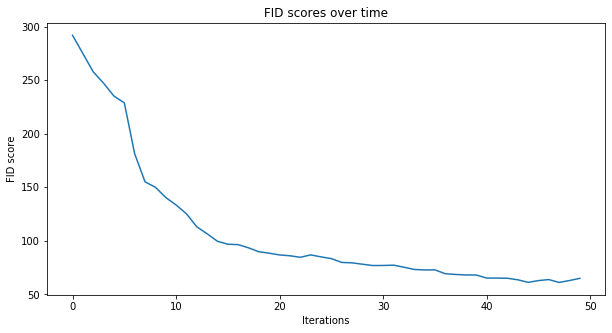

21/10/2019 04:59:49 PM - INFO: Generator model with lowest FID score is ./output/wsagan/generator_epoch_48.pth
21/10/2019 04:59:49 PM - INFO: Saving output of best generator model to ./output/wsagan/best_fake_sample.png


In [4]:
if clean_dirs:
    clean_make_dir(output_path)

logging.info("Dataset path: {}, Output path: {}, Batch Size: {}, Latent Size: {}, Num iterations: {}, Generator unit multiplier: {}, Discriminator unit multiplier: {}, Learning rate: {}".format(path, output_path, batch_size, latent_size, num_epochs, gen_hidden_units, dis_hidden_units, learning_rate))

training_dataset = get_dataset(path, train=True)
# Dropping the last batch as it is sometimes not divisible by batch_size,
# causing errors when trying to feed it to the GAN.
training_data_loader = t.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_dataset_path = "{0}/test".format(path)
testing_dataset = get_dataset(testing_dataset_path, train=False)
testing_data_loader = t.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_data_iter = iter(testing_data_loader)

device = t.device("cpu")
if t.cuda.is_available():
    logging.info("CUDA enabled device found - will use CUDA device")
    device = t.device("cuda:0")

# Init FID calculator
fid_calculator = FID(device=device)

gen_weights = None
generator = WSAGenerator(latent_size=latent_size, gen_hidden_units=gen_hidden_units).to(device)
generator.apply(init_layer_weights)
if gen_weights is not None:
    logging.info("Using weights saved at {} to continue Generator training".format(gen_weights))
    generator.load_state_dict(t.load(gen_weights))

dis_weights = None
discriminator = WSADiscriminator(latent_size=latent_size, dis_hidden_units=dis_hidden_units).to(device)
discriminator.apply(init_layer_weights)
if dis_weights is not None:
    logging.info("Using weights saved at {} to continue Discriminator training".format(dis_weights))
    discriminator.load_state_dict(t.load(dis_weights))

logging.info(generator)
logging.info(discriminator)

noise = t.randn(batch_size, latent_size, 1, 1, device=device)

dis_optimizer = toptimizer.RMSprop(discriminator.parameters(), lr=learning_rate)
gen_optimizer = toptimizer.RMSprop(generator.parameters(), lr=learning_rate)

gen_filenames = []
gen_losses = []
dis_losses = []
fid_scores = []

# START - Training epoch loop
for epoch in range(num_epochs):
    # Variables to hold generated and fake images for FID score calc
    real_image_batch, fake_image_batch = None, None
    # START - Training batch loop
    for idx, data in enumerate(training_data_loader, start=0):
        # DISCRIMINATOR
        # Train discriminator network
        discriminator.zero_grad()
        # Real data
        real_images = data[0].to(device)
        # Batch size
        bs = real_images.size(0)

        output = discriminator(real_images)
        # Hinge loss
        dis_err_real = output.mean()
        # Discriminator output mean for real images
        D_x = output.mean().item()

        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake images using noise
        fake_images = generator(epoch_noise)
        # Discriminator output for fake images
        output = discriminator(fake_images.detach())
        # Hinge loss
        dis_err_fake = output.mean()
        # Discriminator output mean for fake images - before discriminator update
        D_G_z1 = output.mean().item()
        dis_err = -(dis_err_real - dis_err_fake)
        discriminator.zero_grad()
        dis_err.backward()
        dis_optimizer.step()

        for param in discriminator.parameters():
            param.data.clamp_(-0.01, 0.01)

        if idx % critic_iters == 0:
            # GENERATOR
            # Train with fake data
            epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(epoch_noise)
            # Test discriminator again - this time after training it
            output = discriminator(fake_images)
            # Hinge loss
            gen_err = -(output.mean())
            generator.zero_grad()
            gen_err.backward()
            # Discriminator output mean for fake images - after discriminator update
            D_G_z2 = output.mean().item()
            gen_optimizer.step()

            gen_losses.append(gen_err.item())
            dis_losses.append(dis_err.item())

        if idx % log_interval == 0:
            log_info = "Epoch: {}/{}, Sample: {}/{}, Disc Loss: {:.4f}, Gen Loss: {:.4f}".format(epoch + 1, num_epochs, idx + 1, len(training_data_loader), dis_err.item(), gen_err.item())
            if debug_info:
                log_info += ", D(x): {:.4f}, D(G(z)): {:.4f} / {:.4f}".format(D_x, D_G_z1, D_G_z2)
            logging.info(log_info)

        if idx % 200 == 0 or idx == (len(training_data_loader) - 1):
            tutils.save_image(real_images, "{0}/real_samples.png".format(output_path), normalize=True)
            fake_images = generator(noise)
            tutils.save_image(fake_images.detach(), "{0}/fake_samples_epoch_{1}.png".format(output_path, epoch + 1), normalize=True)
        
        if idx % fid_batch_interval == 0:
            # Add to fake image batch for FID score calc
            if fake_image_batch is None:
                fake_image_batch = fake_images.detach()
            else:
                fake_image_batch = t.cat((fake_image_batch, fake_images.detach()), dim=0)
    # END - Training batch loop

    g_weight_filename = "{0}/generator_epoch_{1}.pth".format(output_path, epoch + 1)
    gen_filenames.append(g_weight_filename)
    # Checkpoint model
    t.save(generator.state_dict(), g_weight_filename)
    t.save(discriminator.state_dict(), "{0}/discriminator_epoch_{1}.pth".format(output_path, epoch + 1))

    # Save attention map
    tutils.save_image(discriminator.attn_layer.get_attention(as_image=True), "{0}/discriminator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)
    tutils.save_image(generator.attn_layer.get_attention(as_image=True), "{0}/generator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)

    # Calculate FID scores after each epoch - as it is super slow during normal iterations
    while real_image_batch is None or len(real_image_batch) < len(fake_image_batch):
        try:
            r_im, _ = next(testing_data_iter)
            r_im.to(device=device)
            if real_image_batch is None:
                real_image_batch = r_im
            else:
                real_image_batch = t.cat((real_image_batch, r_im), dim=0)
        except StopIteration:
            testing_data_iter = iter(testing_data_loader)
    fid_score = fid_calculator.calculate_fid(real_image_batch, fake_image_batch, batch_size)
    fid_scores.append(fid_score)
    logging.info("Epoch {} FID score: {}".format(epoch + 1, fid_score))
# END - Training epoch loop

logging.info("FID scores over the epochs: {}".format(fid_scores))
logging.info("Mean FID score: {}".format(mean_fid(fid_scores)))
plot_losses(gen_losses, dis_losses)
plot_fid_scores(fid_scores)

if save_best:
    save_best_generator_image(generator, gen_filenames, fid_scores, noise, output_path)


21/10/2019 04:59:49 PM - INFO: Last image generated


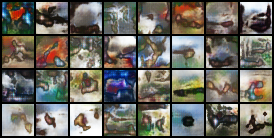

21/10/2019 04:59:49 PM - INFO: Image generated from model with lowest FID score


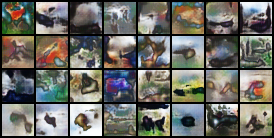

In [5]:
from IPython.display import Image, display

logging.info("Last image generated")
display(Image(filename="{0}/fake_samples_epoch_{1}.png".format(output_path, num_epochs)))
if save_best:
    logging.info("Image generated from model with lowest FID score")
    display(Image(filename="{0}/best_fake_sample.png".format(output_path)))